# GRAPH NEURAL NETWORK
- convolution over graphs is a natural generalization of convolution over images.

**PASSING MESSAGES BETWEEN PARTS OF THE GRAPH**
- we can use **message passing** in order to pass information between nodes:

In order to influence each other embeddings.

message passing works like this:

- we gather all the neighboring node embeddings through **g** function.

- we aggregate the information through a function.

- all pooled messages are passed through an **update function** (neural network).

# PROJECT

In [167]:
# LIBRARIES
import torch
import numpy as np
import pandas as pd
import os
import json
from torch import Tensor
from tqdm import tqdm
import torch.nn as nn
from torch.nn import LayerNorm, GELU
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

The following defines the number of qubits we are considering: 

In [168]:
num_qubits = 20

#### TOPOLOGIES

In [169]:
def make_ising_ring_graph(P_indices):
    """
    P_indices: LongTensor of shape [n],
        0 -> I  (0,0,0)
        1 -> X  (1,0,0)
        2 -> Y  (0,1,0)
        3 -> Z  (0,0,1)

    Returns: PyG Data object with ring topology.
    """
    n = P_indices.size(0)

    # 3-bit encoding for Pauli operators (I, X, Y, Z)
    pauli_map = torch.tensor([
        [0,0,0],  # I
        [1,0,0],  # X
        [0,1,0],  # Y
        [0,0,1],  # Z
    ], dtype=torch.float)

    x = pauli_map[P_indices]   # shape [n, 3]

    # Ring edges
    src = torch.arange(n)
    dst = (src + 1) % n

    # create edges between nodes in the corresponding index of each tensor
    # we create edges in both directions
    edge_index = torch.stack([
        torch.cat([src, dst]),
        torch.cat([dst, src]),
    ], dim=0)

    return Data(x=x, edge_index=edge_index)

In [160]:
def make_ising_line_graph(P_indices):
    """
    P_indices: LongTensor of shape [n],
        0 -> I  (0,0,0)
        1 -> X  (1,0,0)
        2 -> Y  (0,1,0)
        3 -> Z  (0,0,1)

    Creates a PyG Data object with a 1D line topology.
    """
    n = P_indices.size(0)

    # Node features: same 3-bit Pauli encoding
    pauli_map = torch.tensor([
        [0,0,0],  # I
        [1,0,0],  # X
        [0,1,0],  # Y
        [0,0,1],  # Z
    ], dtype=torch.float)

    x = pauli_map[P_indices]   # [n, 3]

    # Line edges: undirected (i <-> i+1)
    src = torch.arange(n - 1)
    dst = src + 1

    # Build edge_index with edges in both directions
    edge_index = torch.stack([
        torch.cat([src, dst]),
        torch.cat([dst, src]),
    ], dim=0)

    return Data(x=x, edge_index=edge_index)

In [161]:
def make_ising_2d_graph(P_indices, height, width):
    """
    P_indices: LongTensor of shape [height * width]
        0 -> I  (0,0,0)
        1 -> X  (1,0,0)
        2 -> Y  (0,1,0)
        3 -> Z  (0,0,1)

    Creates a PyG Data object for a 2D square Ising grid.
        node = r * width + c
    """

    # Node features (same Pauli 3-bit encoding)
    pauli_map = torch.tensor([
        [0,0,0],  # I
        [1,0,0],  # X
        [0,1,0],  # Y
        [0,0,1],  # Z
    ], dtype=torch.float)

    x = pauli_map[P_indices]   # [H*W, 3]

    edges_src = []
    edges_dst = []

    # Connectivity: 4-neighbors (up, down, left, right)
    for r in range(height):
        for c in range(width):
            idx = r * width + c

            # Right neighbor
            if c + 1 < width:
                nbr = r * width + (c + 1)
                edges_src += [idx, nbr]
                edges_dst += [nbr, idx]

            # Down neighbor
            if r + 1 < height:
                nbr = (r + 1) * width + c
                edges_src += [idx, nbr]
                edges_dst += [nbr, idx]

    edge_index = torch.tensor([edges_src, edges_dst], dtype=torch.long)

    return Data(x=x, edge_index=edge_index)

The **DEMON** Model is the best architecture we developed among all our attempts through the semester.

This architecture can predict the future evolution of unseen paulis with high accuracy.

## DEMON

In [170]:
# Message passing layer with PreNorm
class TopologyPropagation(MessagePassing):
    """
    Message passing layer:
    Implements: x = x + sum_j MLP(J * LayerNorm(x_j))
    """
    def __init__(self, dim):
        super().__init__(aggr="add")
        self.norm = nn.LayerNorm(dim)

        # MLP that create 
        # each message before aggregation
        self.msg_mlp = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x, edge_index, J):
        self.J = J

        x_norm = self.norm(x)
        # Nonlinear message passing
        msg = self.propagate(edge_index, x=x_norm)
        return x + msg

    def message(self, x_j):
        return self.msg_mlp(self.J * x_j)


# Node MLP with PreNorm and Residual block
class NodeMLP(nn.Module):
    """
    MultilayerPerceptron block per-node
    """
    def __init__(self, dim, hidden_dim=96, dropout=0.0):
        super().__init__()

        self.norm = LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x_norm = self.norm(x)
        return x + self.mlp(x_norm)

# GNN Layer Block = MessagePassing + NodeMLP
class DemonLayer(nn.Module):
    def __init__(self, dim, hidden_dim=48, dropout=0.1):
        super().__init__()
        self.conv = TopologyPropagation(dim)
        self.mlp = NodeMLP(dim, hidden_dim, dropout)

    def forward(self, x, edge_index, J):
        x = self.conv(x, edge_index, J)
        x = self.mlp(x)
        return x

# THE DEMON MODEL
class Demon(nn.Module):
    """
    Main DEMON GNN model
    The Hardcoded parameters are tuned.
    The output is a scalar.
    """
    def __init__(self,
                 num_layers,
                 base_dim=3,
                 hidden_dim=96,
                 expansion_ratio=8,
                 dropout=0.0):
        super().__init__()

        model_dim = num_layers * expansion_ratio
        self.input_proj = nn.Linear(base_dim, model_dim)

        self.layers = nn.ModuleList([
            DemonLayer(model_dim, hidden_dim, dropout)
            for _ in range(num_layers)
        ])

        self.readout_mlp = nn.Sequential(
            nn.Linear(model_dim, model_dim),
            nn.GELU(),
            nn.Linear(model_dim, 1)
        )

    def forward(self, x, edge_index, J):
        x = self.input_proj(x)

        for layer in self.layers:
            x = layer(x, edge_index, J)

        graph_rep = x.mean(dim=0)
        return self.readout_mlp(graph_rep).squeeze()

### HYPERPARAMETER TUNING

In [163]:
import itertools

In [171]:
def build_graph_dataset(pauli_ints, labels, num_qubits):
    """
    INPUT:
        Pauli strings in integer form.
        Associated labels.
    RETURNS:
        graphs : list of Data objects
    """
    graphs = []

    for x, y in zip(pauli_ints, labels):
        
        # This convert integer → Pauli index sequence
        P_indices = pauli_digits_from_int(x, num_qubits)
        P_indices = torch.tensor(P_indices, dtype=torch.long).view(-1)

        # We build the PyG graph
        data = make_ising_ring_graph(P_indices)

        # We attach the label to the graph
        data.y = torch.tensor([float(y)], dtype=torch.float32)

        graphs.append(data)

    return graphs

In [172]:
def pauli_digits_from_int(x: int, n: int):
    """
    Convert integer → base-4 digits [0,1,2,3] of length n.
    """
    digits = []
    for _ in range(n):
        digits.append(x % 4)
        x //= 4
    return torch.tensor(digits, dtype=torch.long)

In [173]:
json_path = "len=100004_qbits=20_{Gen=true_L1=32_cp=0.00123418_w=Inf}_{L2=2_cp=1.0e-15}.json"

with open(json_path) as f:
    data_dict = json.load(f)

base_name = os.path.splitext(json_path)[0]   # remove .json
model_save_path = f"best_demon_{base_name}.pth"

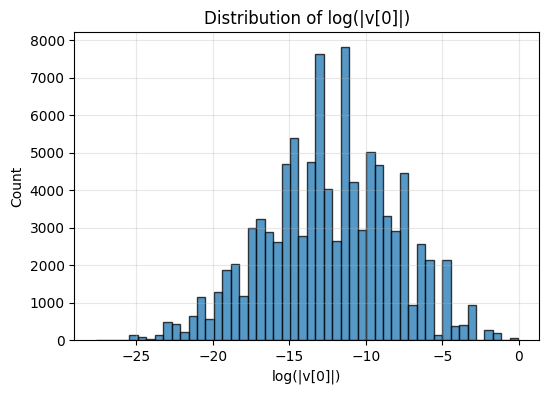

In [174]:
# data_dict contains mulitples possible metrics that can be used as labels.
pauli_ints_raw = [int(k) for k in data_dict.keys()] 
# v[0] is the label we decided to consider: the overlap with zero.
vals_v0_raw = [float(v[0]) for v in data_dict.values()]
vals_v0_abs = [abs(v) for v in vals_v0_raw]          

# Filter out very small values 
# since we cannot apply log function on them.
filtered_pauli_ints = []
filtered_vals_abs = []

# ----------------------------------------------------------
for p, val_abs in zip(pauli_ints_raw, vals_v0_abs):
    if val_abs >= 1e-40:
        filtered_pauli_ints.append(p)
        filtered_vals_abs.append(val_abs)

# Take log-scale of the values
labels = torch.log(torch.tensor(filtered_vals_abs, dtype=torch.float))
# ----------------------------------------------------------

# Plot distribution of the labels 
# (log-values)
plt.figure(figsize=(6,4))
plt.hist(labels.numpy(), bins=50, alpha=0.75, edgecolor="black")
plt.xlabel("log(|v[0]|)")
plt.ylabel("Count")
plt.title("Distribution of log(|v[0]|)")
plt.grid(alpha=0.3)
plt.show()

In [175]:
# Train / Validation Split
# -------------------------
train_ints, val_ints, train_labels, val_labels = train_test_split(
    filtered_pauli_ints, labels, test_size=0.05, random_state=42
)

# we select a subset 
# for hyperparameter tuning
subset_size = 5000 
rng = np.random.default_rng(42)
subset_idx = rng.choice(len(train_ints), size=subset_size, replace=False)
train_ints_subset   = [train_ints[i] for i in subset_idx]
train_labels_subset = [train_labels[i] for i in subset_idx]
train_graphs = build_graph_dataset(train_ints_subset, train_labels_subset, num_qubits)
#------------------------------------------------------------

val_graphs = build_graph_dataset(val_ints, val_labels, num_qubits)

print("Train graphs:", len(train_graphs))
print("Val graphs:", len(val_graphs))

# DataLoaders
# ------------
train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=1, shuffle=False)

/var/folders/n_/nv7jjvvn7kvbmnzcz9d1hjzr0000gn/T/ipykernel_2569/1730673205.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  P_indices = torch.tensor(P_indices, dtype=torch.long).view(-1)


Train graphs: 5000
Val graphs: 4973


In [25]:
def train_one_model(hidden_dim, expansion_ratio, dropout, num_layers=2):

    model = Demon(
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        expansion_ratio=expansion_ratio,
        dropout=dropout
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.MSELoss()

    T_max = 10
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=T_max, eta_min=1e-5
    )

    J = 1
    epochs = 10

    best_val_loss = float('inf')
    prev_val_loss = float('inf')
    val_increase_counter = 0
    patience = 3

    for epoch in range(epochs):
        # TRAIN
        model.train()
        total_train_loss = 0.0

        for data in train_loader:
            target = data.y.squeeze()

            pred = model(data.x, data.edge_index, J)
            loss = criterion(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        scheduler.step()

        # VALIDATION 
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for val_data in val_loader:
                target = val_data.y.squeeze()
                pred = model(val_data.x, val_data.edge_index, J)
                loss = criterion(pred, target)
                total_val_loss += loss.item()

        mean_val_loss = total_val_loss / len(val_loader)

        # we introduced early sotpping criteria 
        # in order to detect overfitting
        if mean_val_loss > prev_val_loss:
            val_increase_counter += 1
        else:
            val_increase_counter = 0
        prev_val_loss = mean_val_loss
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
        if val_increase_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return best_val_loss

In [45]:
grid = {
    "hidden_dim": [24, 48, 96],
    "expansion_ratio": [8, 16, 32, 64],
    "dropout": [0.0, 0.1, 0.2],
} # we are considering a total of 3x4x3 = 36 models

In [27]:
# -----------------------------------
# GRID SEARCH: all 36 combinations
# -----------------------------------

all_combos = list(itertools.product(
    grid["hidden_dim"],
    grid["expansion_ratio"],
    grid["dropout"]
))

results = []
print(f"Running grid search over {len(all_combos)} models...\n")

for (hidden_dim, expansion_ratio, dropout) in tqdm(all_combos):
    val_loss = train_one_model(hidden_dim, expansion_ratio, dropout)
    
    results.append({
        "hidden_dim": hidden_dim,
        "expansion_ratio": expansion_ratio,
        "dropout": dropout,
        "val_loss": val_loss
    })

results_df = pd.DataFrame(results)

Running grid search over 36 models...



 31%|███       | 11/36 [1:03:42<2:52:31, 414.05s/it]

Early stopping at epoch 10


 33%|███▎      | 12/36 [1:11:39<2:53:16, 433.18s/it]

Early stopping at epoch 9


100%|██████████| 36/36 [9:35:18<00:00, 958.85s/it]   


In [28]:
# Save results
results_df.to_csv("grid_search_results.csv", index=False)
print("\nGrid search complete!")
print(results_df.sort_values("val_loss").head())


Grid search complete!
    hidden_dim  expansion_ratio  dropout  val_loss
24          96                8      0.0  0.000156
0           24                8      0.0  0.000421
26          96                8      0.2  0.006574
28          96               16      0.1  0.008639
4           24               16      0.1  0.009325


In [29]:
best_row = results_df.loc[results_df['val_loss'].idxmin()]

In [30]:
best_row.to_dict()

{'hidden_dim': 96.0,
 'expansion_ratio': 8.0,
 'dropout': 0.0,
 'val_loss': 0.00015601978811273992}

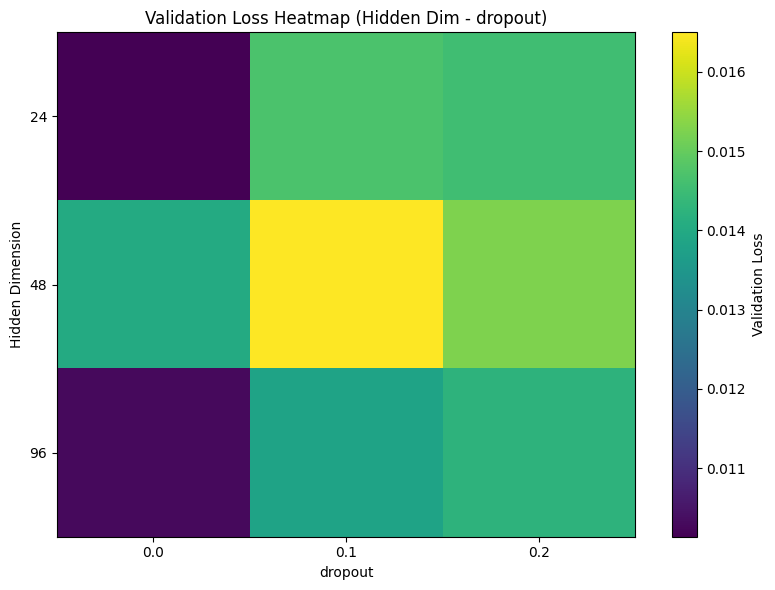

In [198]:
df = pd.read_csv("grid_search_results.csv")

heatmap_df = df.pivot_table(
    index="hidden_dim",
    columns="dropout",
    values="val_loss",
    aggfunc="mean"
)

heatmap_df = heatmap_df.sort_index().sort_index(axis=1)
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap_df.values,
    aspect="auto",
    cmap="viridis"
)

plt.colorbar(im, label="Validation Loss")

plt.xticks(
    ticks=np.arange(len(heatmap_df.columns)),
    labels=heatmap_df.columns
)
plt.yticks(
    ticks=np.arange(len(heatmap_df.index)),
    labels=heatmap_df.index
)

plt.xlabel("dropout")
plt.ylabel("Hidden Dimension")
plt.title("Validation Loss Heatmap (Hidden Dim - dropout)")
plt.tight_layout()
plt.show()

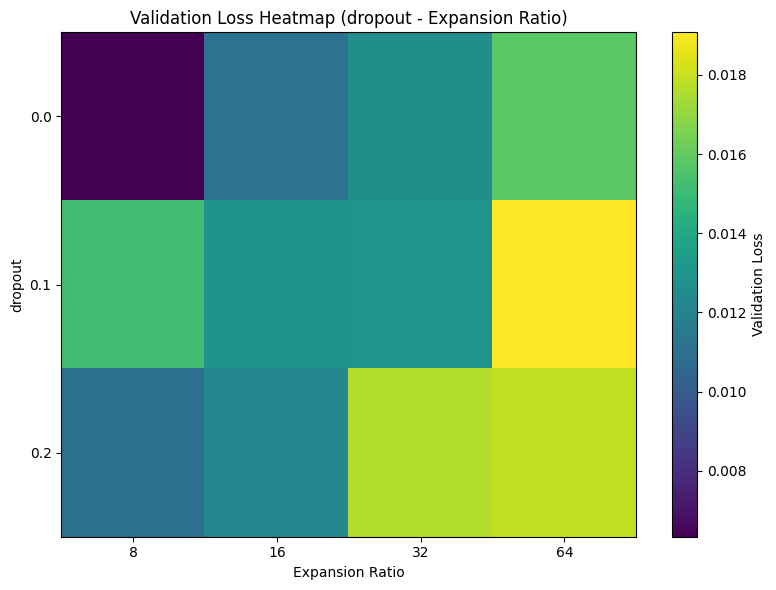

In [199]:
df = pd.read_csv("grid_search_results.csv")

heatmap_df = df.pivot_table(
    index="dropout",
    columns="expansion_ratio",
    values="val_loss",
    aggfunc="mean"
)

heatmap_df = heatmap_df.sort_index().sort_index(axis=1)
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap_df.values,
    aspect="auto",
    cmap="viridis"
)

plt.colorbar(im, label="Validation Loss")

plt.xticks(
    ticks=np.arange(len(heatmap_df.columns)),
    labels=heatmap_df.columns
)
plt.yticks(
    ticks=np.arange(len(heatmap_df.index)),
    labels=heatmap_df.index
)

plt.xlabel("Expansion Ratio")
plt.ylabel("dropout")
plt.title("Validation Loss Heatmap (dropout - Expansion Ratio)")
plt.tight_layout()
plt.show()

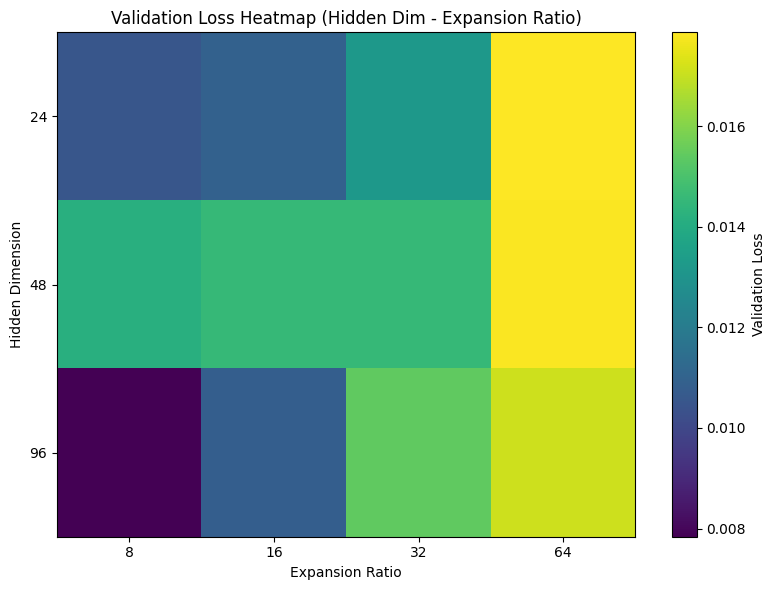

In [200]:
df = pd.read_csv("grid_search_results.csv")

heatmap_df = df.pivot_table(
    index="hidden_dim",
    columns="expansion_ratio",
    values="val_loss",
    aggfunc="mean"
)

heatmap_df = heatmap_df.sort_index().sort_index(axis=1)
plt.figure(figsize=(8, 6))
im = plt.imshow(
    heatmap_df.values,
    aspect="auto",
    cmap="viridis"
)

plt.colorbar(im, label="Validation Loss")

plt.xticks(
    ticks=np.arange(len(heatmap_df.columns)),
    labels=heatmap_df.columns
)
plt.yticks(
    ticks=np.arange(len(heatmap_df.index)),
    labels=heatmap_df.index
)

plt.xlabel("Expansion Ratio")
plt.ylabel("Hidden Dimension")
plt.title("Validation Loss Heatmap (Hidden Dim - Expansion Ratio)")
plt.tight_layout()
plt.show()

### TRAINING AND VALIDATION

We extract 5k data inputs for testing and we ensure to have a subset disjoint from the one used for hyperparameter tuning.

In [176]:
test_subset_size = 5000
# all indices in training set
all_train_idx = np.arange(len(train_ints))
# We remove indices already used in tuning subset
remaining_idx = np.setdiff1d(all_train_idx, subset_idx)

# sample test subset 
# from remaining indices
test_subset_idx = rng.choice(
    remaining_idx,
    size=test_subset_size,
    replace=False
)

test_ints_subset   = [train_ints[i] for i in test_subset_idx]
test_labels_subset = [train_labels[i] for i in test_subset_idx]

test_graphs = build_graph_dataset(
    test_ints_subset,
    test_labels_subset,
    num_qubits
)

print("Test graphs (disjoint):", len(test_graphs))

/var/folders/n_/nv7jjvvn7kvbmnzcz9d1hjzr0000gn/T/ipykernel_2569/1730673205.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  P_indices = torch.tensor(P_indices, dtype=torch.long).view(-1)


Test graphs (disjoint): 5000


In [177]:
final_train_idx = np.setdiff1d(
    np.arange(len(train_ints)),
    test_subset_idx
)

final_train_ints   = [train_ints[i] for i in final_train_idx]
final_train_labels = [train_labels[i] for i in final_train_idx]

final_train_graphs = build_graph_dataset(
    final_train_ints,
    final_train_labels,
    num_qubits
)

print("Final train graphs:", len(final_train_graphs))

/var/folders/n_/nv7jjvvn7kvbmnzcz9d1hjzr0000gn/T/ipykernel_2569/1730673205.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  P_indices = torch.tensor(P_indices, dtype=torch.long).view(-1)


Final train graphs: 89481


In [178]:
# DataLoaders
# ---------------
train_loader = DataLoader(final_train_graphs, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=1, shuffle=False)

# 3. Model
# ----------
model = Demon(num_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
T_max = 10  

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=T_max,
    eta_min=1e-5   
)

Epoch 1/10 [TRAIN]:   0%|          | 0/89481 [00:00<?, ?it/s, train_loss=181]

New best model saved at epoch 1 (val loss = 0.001709)


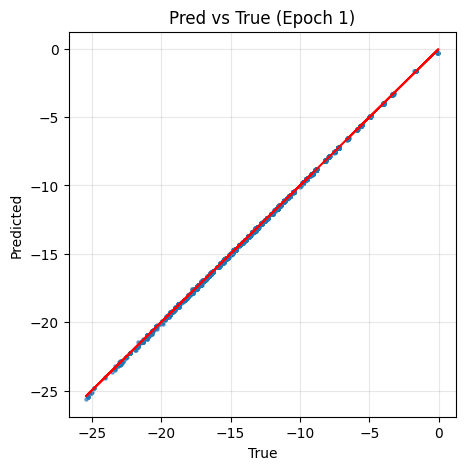

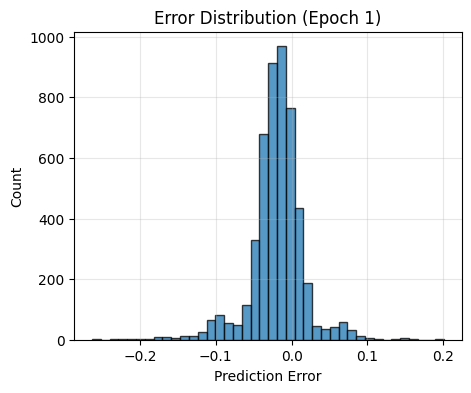

Epoch 1/10 — Train Loss: 0.256188 | Val Loss: 0.001709


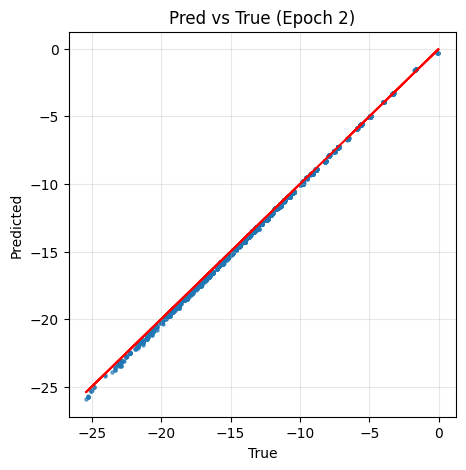

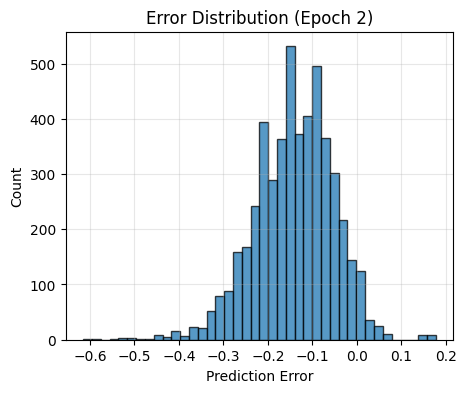

Epoch 2/10 — Train Loss: 0.006569 | Val Loss: 0.028009


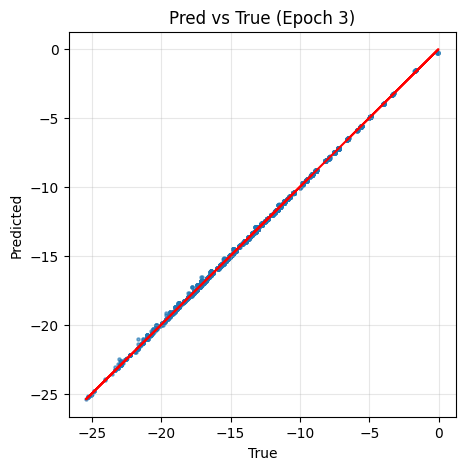

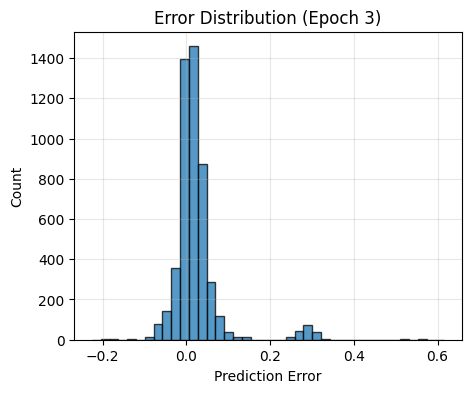

Epoch 3/10 — Train Loss: 0.005119 | Val Loss: 0.004319


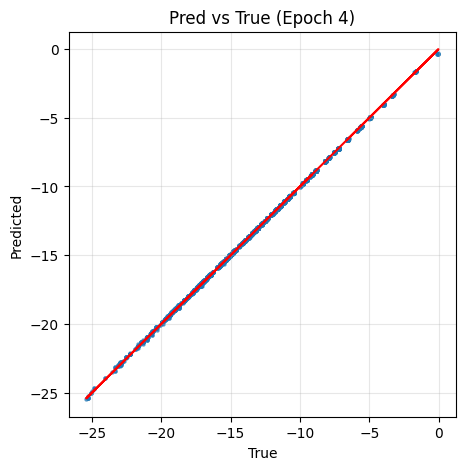

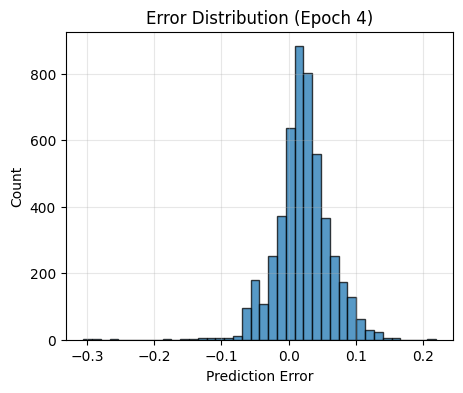

Epoch 4/10 — Train Loss: 0.003947 | Val Loss: 0.002054


New best model saved at epoch 5 (val loss = 0.000827)


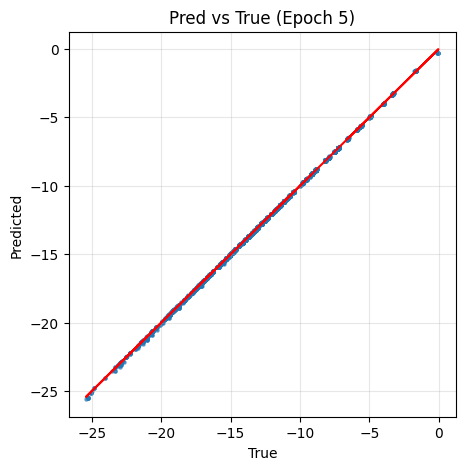

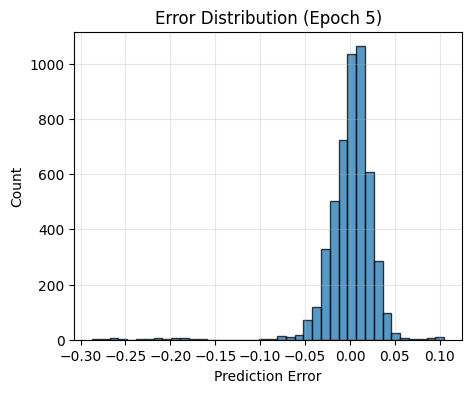

Epoch 5/10 — Train Loss: 0.003108 | Val Loss: 0.000827


New best model saved at epoch 6 (val loss = 0.000599)


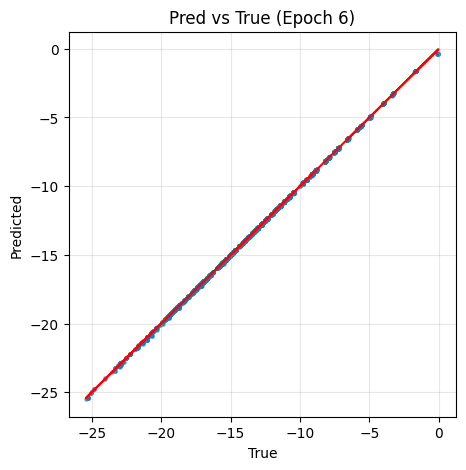

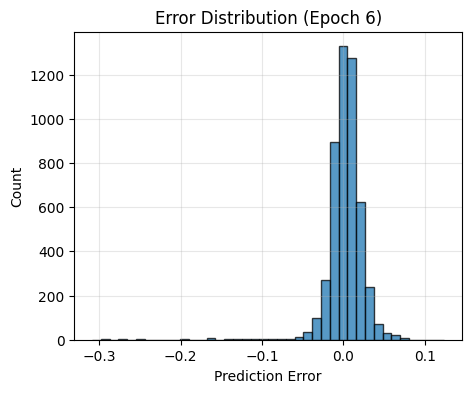

Epoch 6/10 — Train Loss: 0.002408 | Val Loss: 0.000599


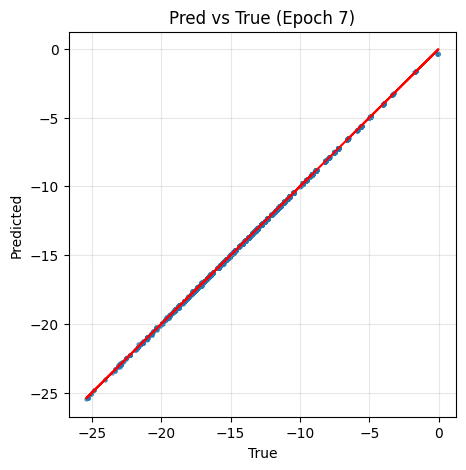

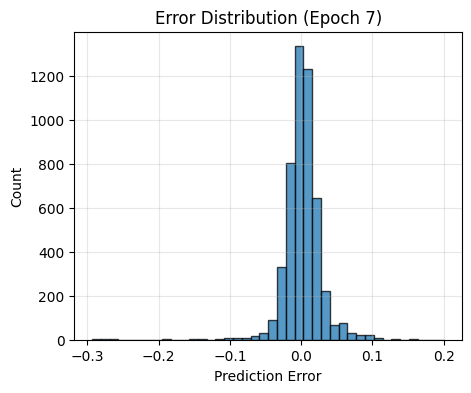

Epoch 7/10 — Train Loss: 0.001546 | Val Loss: 0.000713


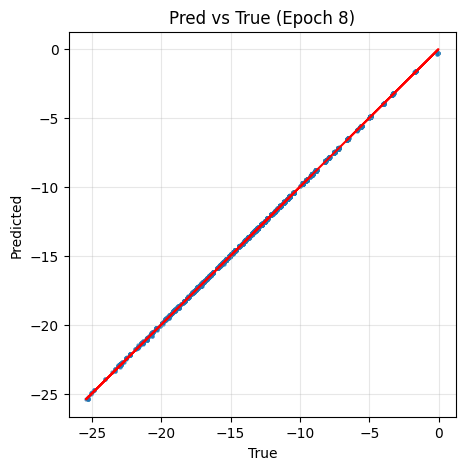

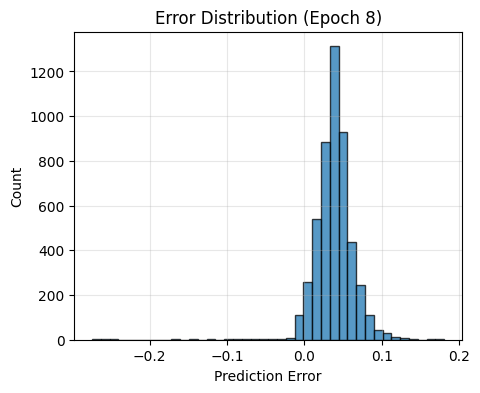

Epoch 8/10 — Train Loss: 0.001008 | Val Loss: 0.002099


New best model saved at epoch 9 (val loss = 0.000455)


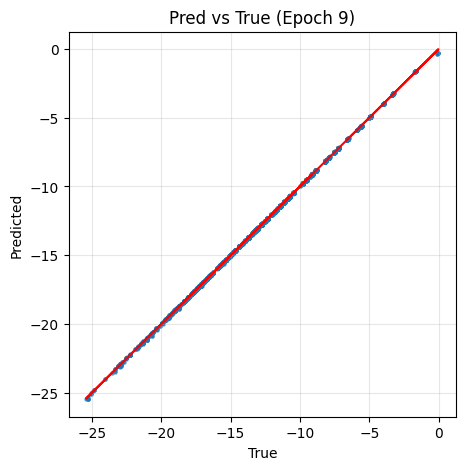

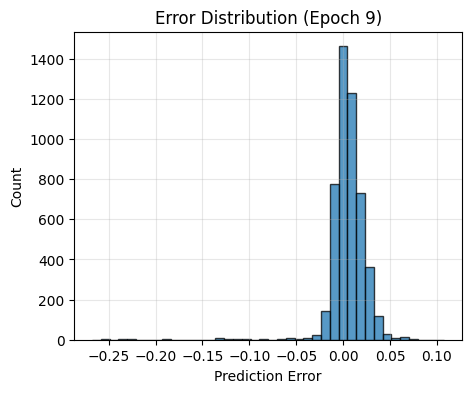

Epoch 9/10 — Train Loss: 0.000638 | Val Loss: 0.000455


New best model saved at epoch 10 (val loss = 0.000406)


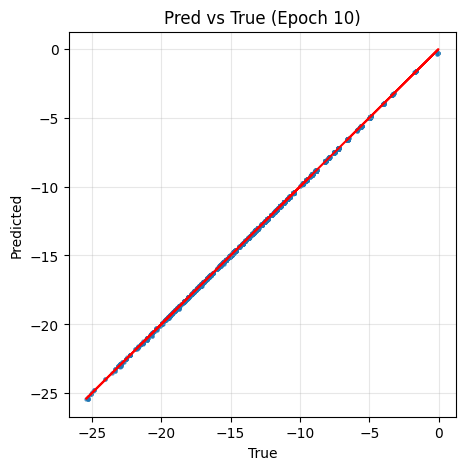

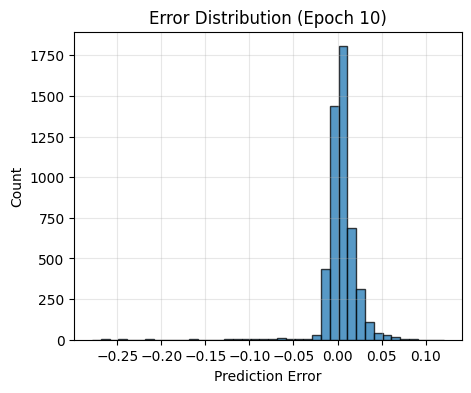

Epoch 10/10 — Train Loss: 0.000445 | Val Loss: 0.000406


In [151]:
J = 1
epochs = 10

training_dir = "training"
os.makedirs(training_dir, exist_ok=True)

train_loss_history = []
val_loss_history = []

best_val_loss = float("inf")
best_state_dict = None

# Training Loop

for epoch in range(epochs):

    # TRAIN
    model.train()
    total_train_loss = 0.0

    pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{epochs} [TRAIN]",
        leave=False
    )

    for data in pbar:
        x = data.x
        edge_index = data.edge_index
        target = data.y.squeeze()

        pred = model(x, edge_index, J)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        pbar.set_postfix(train_loss=loss.item())

    mean_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(mean_train_loss)

    scheduler.step()

    # VALIDATION 
    model.eval()
    total_val_loss = 0.0
    val_preds = []
    val_trues = []

    with torch.no_grad():
        for val_data in val_loader:
            x = val_data.x
            edge_index = val_data.edge_index
            target = val_data.y.squeeze()

            pred = model(x, edge_index, J)
            loss = criterion(pred, target)

            total_val_loss += loss.item()
            val_preds.append(pred.item())
            val_trues.append(target.item())

    mean_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(mean_val_loss)


    # Save best model
    # -----------------
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        best_state_dict = model.state_dict()
        torch.save(best_state_dict, model_save_path)
        print(
            f"New best model saved at epoch {epoch+1} "
            f"(val loss = {best_val_loss:.6f})"
        )


    # WE OVERWRITE — TRAIN LOSS
    plt.figure(figsize=(6, 4))
    plt.plot(train_loss_history, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title("Training Loss Curve")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(training_dir, "train_loss.png"))
    plt.close()

    # WE OVERWRITE — VAL LOSS
    plt.figure(figsize=(6, 4))
    plt.plot(val_loss_history, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss Curve")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(training_dir, "val_loss.png"))
    plt.close()

    np.savetxt(
        os.path.join(training_dir, "train_loss.txt"),
        np.array(train_loss_history)
    )

    np.savetxt(
        os.path.join(training_dir, "val_loss.txt"),
        np.array(val_loss_history)
    )

    # PLOTS — DISPLAY ONLY
    pred_tensor = torch.tensor(val_preds)
    val_targets_tensor = torch.tensor(val_trues)

    # PLOT — TRUE vs PRED
    plt.figure(figsize=(5, 5))
    plt.scatter(
        val_targets_tensor.numpy(),
        pred_tensor.numpy(),
        s=5,
        alpha=0.6
    )
    plt.plot(
        val_targets_tensor.numpy(),
        val_targets_tensor.numpy(),
        'r'
    )
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"Pred vs True (Epoch {epoch+1})")
    plt.grid(alpha=0.3)
    plt.show()
    plt.close()

    # PLOT — ERROR HISTOGRAM
    errors = pred_tensor - val_targets_tensor

    plt.figure(figsize=(5, 4))
    plt.hist(
        errors.numpy(),
        bins=40,
        edgecolor='black',
        alpha=0.75
    )
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.title(f"Error Distribution (Epoch {epoch+1})")
    plt.grid(alpha=0.3)
    plt.show()
    plt.close()

    print(
        f"Epoch {epoch+1}/{epochs} — "
        f"Train Loss: {mean_train_loss:.6f} | "
        f"Val Loss: {mean_val_loss:.6f}"
    )

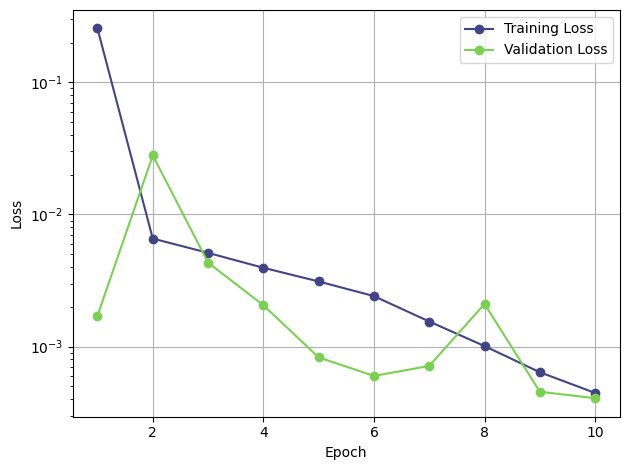

In [156]:
train_loss = np.loadtxt("training/train_loss.txt")
val_loss = np.loadtxt("training/val_loss.txt")
epochs = np.arange(1, len(train_loss) + 1)

cmap = plt.cm.viridis
train_color = cmap(0.2)
val_color = cmap(0.8)

# Plot
plt.figure()
plt.plot(
    epochs, train_loss,
    marker='o',
    label="Training Loss",
    color=train_color
)
plt.plot(
    epochs, val_loss,
    marker='o',
    label="Validation Loss",
    color=val_color
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### TEST AND EVALUATION

In [179]:
# TEST EVALUATION 
# ----------------

J = 1

model_path = (
    "best_demon_len=100004_qbits=20_"
    "{Gen=true_L1=32_cp=0.00123418_w=Inf}_"
    "{L2=2_cp=1.0e-15}.pth"
)

# We load best Demon model
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

print(f"Loaded model from: {model_path}")

test_ints   = [train_ints[i] for i in test_subset_idx]
test_labels = [train_labels[i] for i in test_subset_idx]

test_graphs = build_graph_dataset(
    test_ints,
    test_labels,
    num_qubits
)

test_loader = DataLoader(
    test_graphs,
    batch_size=1,
    shuffle=False
)

print("Test graphs:", len(test_graphs))

Loaded model from: best_demon_len=100004_qbits=20_{Gen=true_L1=32_cp=0.00123418_w=Inf}_{L2=2_cp=1.0e-15}.pth


/var/folders/n_/nv7jjvvn7kvbmnzcz9d1hjzr0000gn/T/ipykernel_2569/1730673205.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  P_indices = torch.tensor(P_indices, dtype=torch.long).view(-1)


Test graphs: 5000


In [180]:
# Run test evaluation
# --------------------
test_loss = 0.0
test_preds = []
test_trues = []

with torch.no_grad():
    for data in test_loader:
        x = data.x
        edge_index = data.edge_index
        target = data.y.squeeze()

        pred = model(x, edge_index, J)
        loss = criterion(pred, target)

        test_loss += loss.item()
        test_preds.append(pred.item())
        test_trues.append(target.item())

mean_test_loss = test_loss / len(test_loader)

y_pred = torch.tensor(test_preds).numpy()
y_true = torch.tensor(test_trues).numpy()
r2  = r2_score(y_true, y_pred)

print("\nFINAL TEST METRICS")
print(f"Test Loss : {mean_test_loss:.6f}")
print(f"R²        : {r2:.6f}")


FINAL TEST METRICS
Test Loss : 0.000346
R²        : 0.999980


### BASELINE NEURAL NETWORK

In [187]:
class NeuralNetwork(nn.Module):
    """
    Fully-connected baseline 
    It takes advantage of the same structures from the Demon model
    Without including Message passing step.
    """
    def __init__(self,
                 num_layers,
                 num_nodes,
                 base_dim=3,
                 hidden_dim=96,
                 expansion_ratio=32,
                 dropout=0.0):
        super().__init__()

        model_dim = num_layers * expansion_ratio
        input_dim = num_nodes * base_dim

        self.input_proj = nn.Linear(input_dim, model_dim)

        self.layers = nn.ModuleList([
            NodeMLP(model_dim, hidden_dim, dropout)
            for _ in range(num_layers)
        ])

        self.readout = nn.Sequential(
            nn.Linear(model_dim, model_dim),
            nn.GELU(),
            nn.Linear(model_dim, 1)
        )

    def forward(self, x):
        # x: [B, num_nodes, base_dim]
        x = x.view(x.size(0), -1)
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x)
        return self.readout(x).squeeze(-1)

In [181]:
model_save_path = f"best_NN_{base_name}.pth"

In [182]:
def pauli_int_to_node_features(pauli_int: int, num_qubits: int, base_dim=3):
    """
    Convert Pauli integer → node feature tensor [num_qubits, base_dim]

    Encoding:
        0 (I) → [0, 0, 0]
        1 (X) → [1, 0, 0]
        2 (Y) → [0, 1, 0]
        3 (Z) → [0, 0, 1]
    """
    assert base_dim == 3, "This encoding assumes base_dim = 3 (X,Y,Z)"

    digits = pauli_digits_from_int(pauli_int, num_qubits)

    x = torch.zeros(num_qubits, base_dim, dtype=torch.float)

    x[digits == 1, 0] = 1.0  # X
    x[digits == 2, 1] = 1.0  # Y
    x[digits == 3, 2] = 1.0  # Z

    return x

In [183]:
def build_fc_dataset(pauli_ints, labels, num_nodes, base_dim=3):
    dataset = []

    for p, y in zip(pauli_ints, labels):
        # Must return [num_nodes, base_dim]
        x = pauli_int_to_node_features(p, num_nodes, base_dim)

        dataset.append((x, y))

    return dataset

In [184]:
# Train / Validation Split
# ----------------------------
train_ints, val_ints, train_labels, val_labels = train_test_split(
    filtered_pauli_ints, labels, test_size=0.05, random_state=42
)

# subset for 
# hyperparameter tuning
subset_size = 5000
rng = np.random.default_rng(42)
subset_idx = rng.choice(len(train_ints), size=subset_size, replace=False)
train_ints_subset   = [train_ints[i] for i in subset_idx]
train_labels_subset = [train_labels[i] for i in subset_idx]

In [185]:
train_data = build_fc_dataset(
    train_ints_subset,
    train_labels_subset,
    num_nodes=num_qubits
)

val_data = build_fc_dataset(
    val_ints,
    val_labels,
    num_nodes=num_qubits
)

print("Train samples:", len(train_data))
print("Val samples:", len(val_data))

Train samples: 5000
Val samples: 4973


In [188]:
# DataLoaders
# ---------------
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=1, shuffle=False)

# Model
# ---------
model = NeuralNetwork(num_layers=2, num_nodes=num_qubits)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
T_max = 10  

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=T_max,
    eta_min=1e-5   
)

In [48]:
def train_one_model_fc(hidden_dim, expansion_ratio, dropout, num_layers=2):

    model = NeuralNetwork(
        num_layers=num_layers,
        num_nodes=num_qubits,
        hidden_dim=hidden_dim,
        expansion_ratio=expansion_ratio,
        dropout=dropout
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=1e-3, weight_decay=1e-4
    )
    criterion = nn.MSELoss()

    T_max = 10
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=T_max, eta_min=1e-5
    )

    epochs = 10
    patience = 3

    best_val_loss = float('inf')
    prev_val_loss = float('inf')
    val_increase_counter = 0

    for epoch in range(epochs):

        # TRAIN
        model.train()
        total_train_loss = 0.0

        for x, y in train_loader:
            y = y.view(-1)  

            preds = model(x) # [B]
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        scheduler.step()

        # VALIDATION
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for x, y in val_loader:
                y = y.view(-1)  
                preds = model(x)
                loss = criterion(preds, y)
                total_val_loss += loss.item()

        mean_val_loss = total_val_loss / len(val_loader)

        # EARLY STOPPING
        if mean_val_loss > prev_val_loss:
            val_increase_counter += 1
        else:
            val_increase_counter = 0

        prev_val_loss = mean_val_loss

        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss

        if val_increase_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return best_val_loss

In [49]:
# -----------------------------------
# GRID SEARCH: all 36 combinations
# -----------------------------------

all_combos = list(itertools.product(
    grid["hidden_dim"],
    grid["expansion_ratio"],
    grid["dropout"]
))

results = []
print(f"Running grid search over {len(all_combos)} models...\n")

for (hidden_dim, expansion_ratio, dropout) in tqdm(all_combos):
    val_loss = train_one_model_fc(hidden_dim, expansion_ratio, dropout)
    
    results.append({
        "hidden_dim": hidden_dim,
        "expansion_ratio": expansion_ratio,
        "dropout": dropout,
        "val_loss": val_loss
    })

results_df = pd.DataFrame(results)

Running grid search over 36 models...



100%|██████████| 36/36 [1:46:41<00:00, 177.83s/it]


In [50]:
# Save results
results_df.to_csv("baseline_grid_search_results.csv", index=False)
print("\nGrid search complete!")
print(results_df.sort_values("val_loss").head())


Grid search complete!
    hidden_dim  expansion_ratio  dropout  val_loss
30          96               32      0.0  0.028163
18          48               32      0.0  0.028686
15          48               16      0.0  0.029109
27          96               16      0.0  0.030768
3           24               16      0.0  0.032989


In [189]:
test_subset_size = 5000
# all indices in training set
all_train_idx = np.arange(len(train_ints))
# remove indices already used in tuning subset
remaining_idx = np.setdiff1d(all_train_idx, subset_idx)

# sample test subset 
# from remaining indices
test_subset_idx = rng.choice(
    remaining_idx,
    size=test_subset_size,
    replace=False
)

test_ints_subset   = [train_ints[i] for i in test_subset_idx]
test_labels_subset = [train_labels[i] for i in test_subset_idx]

In [190]:
final_train_idx = np.setdiff1d(
    np.arange(len(train_ints)),
    test_subset_idx
)

final_train_ints   = [train_ints[i] for i in final_train_idx]
final_train_labels = [train_labels[i] for i in final_train_idx]

In [191]:
train_data = build_fc_dataset(
    final_train_ints,
    final_train_labels,
    num_nodes=num_qubits
)

print("Train samples:", len(train_data))
print("Val samples:", len(val_data))

Train samples: 89481
Val samples: 4973


In [192]:
# DataLoaders
# ------------
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=1, shuffle=False)

# Model
# ---------
model = NeuralNetwork(num_layers=2, num_nodes=num_qubits)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
T_max = 10  

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=T_max,
    eta_min=1e-5   
)

New best model saved at epoch 1 (val loss = 0.073387)


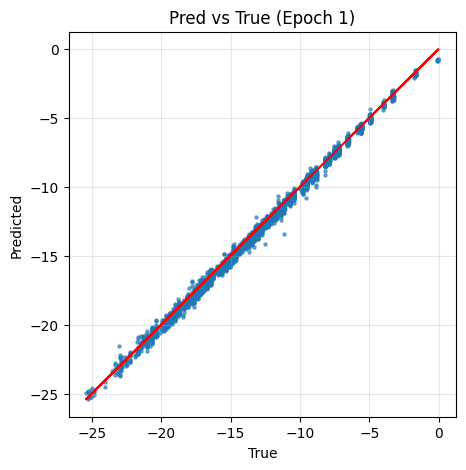

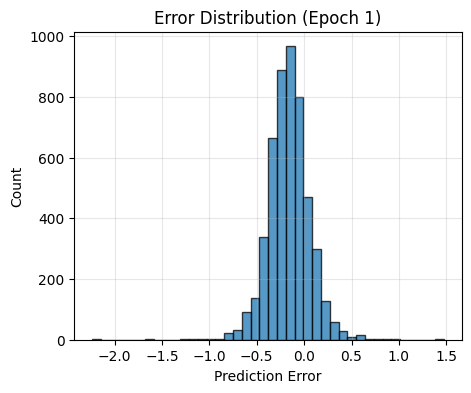

Epoch 1/10 — Train Loss: 0.471601 | Val Loss: 0.073387


New best model saved at epoch 2 (val loss = 0.047104)


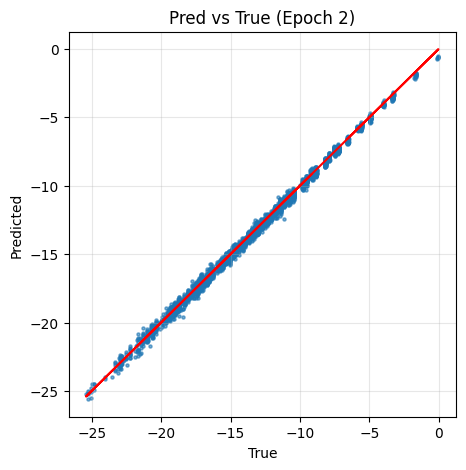

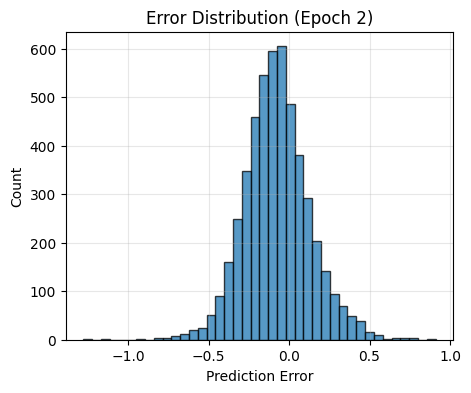

Epoch 2/10 — Train Loss: 0.080044 | Val Loss: 0.047104


New best model saved at epoch 3 (val loss = 0.024337)


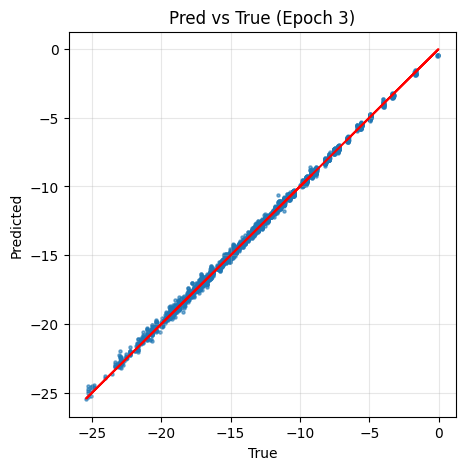

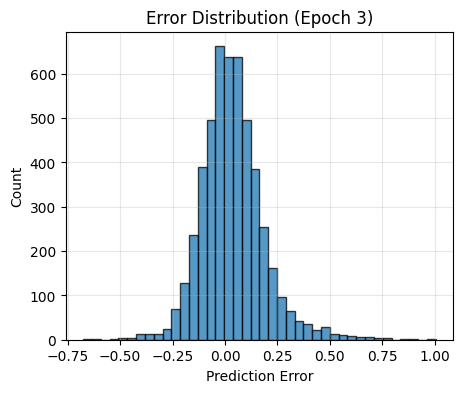

Epoch 3/10 — Train Loss: 0.047436 | Val Loss: 0.024337


New best model saved at epoch 4 (val loss = 0.018283)


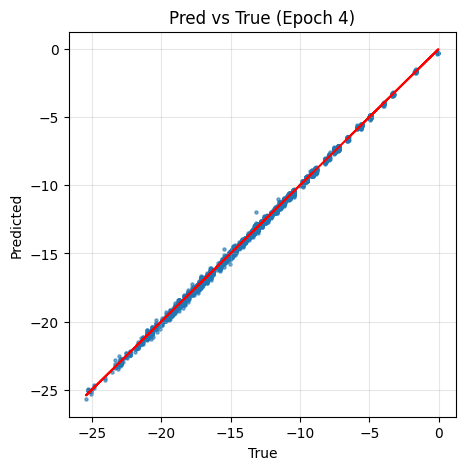

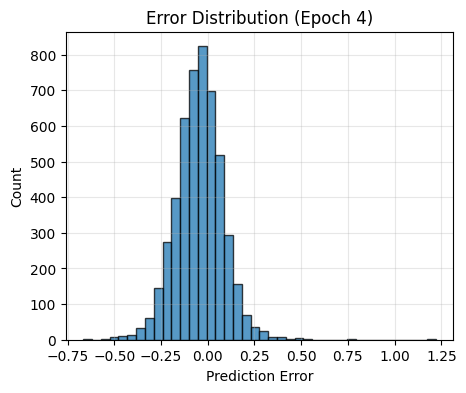

Epoch 4/10 — Train Loss: 0.032520 | Val Loss: 0.018283


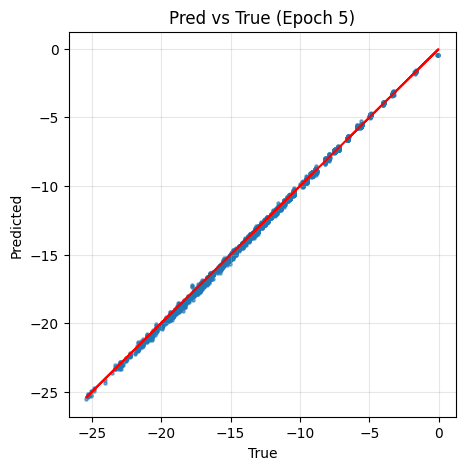

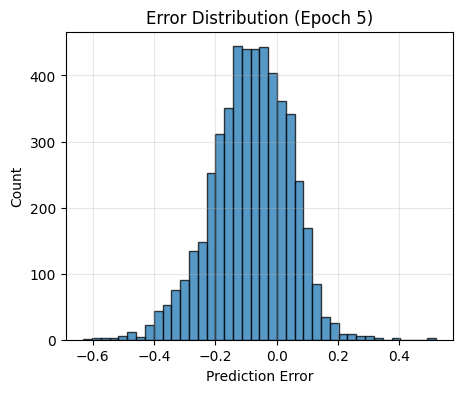

Epoch 5/10 — Train Loss: 0.022640 | Val Loss: 0.023062


New best model saved at epoch 6 (val loss = 0.009850)


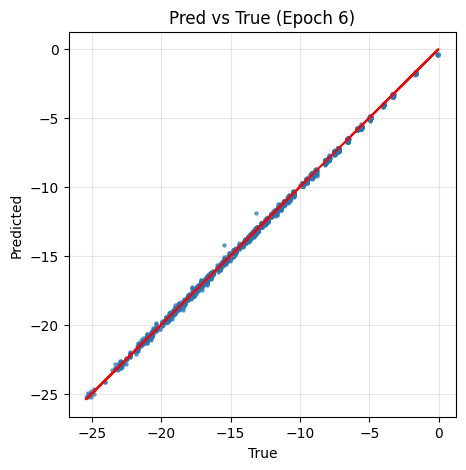

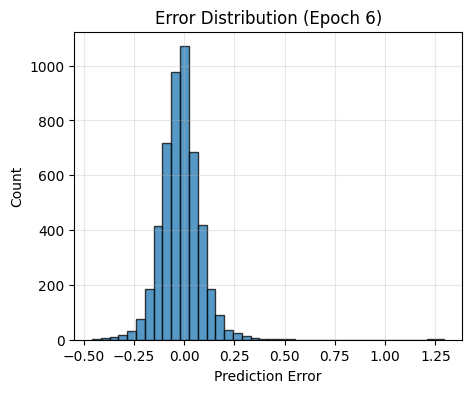

Epoch 6/10 — Train Loss: 0.015026 | Val Loss: 0.009850


New best model saved at epoch 7 (val loss = 0.005510)


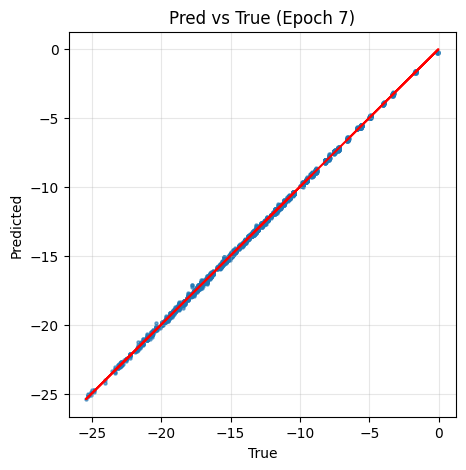

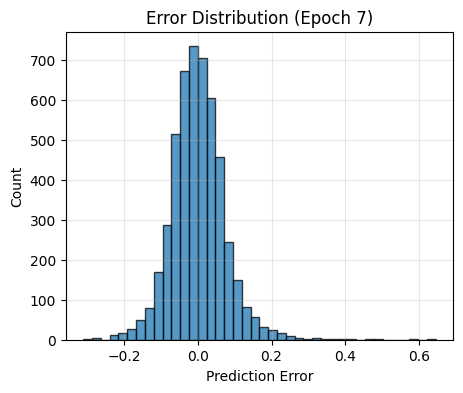

Epoch 7/10 — Train Loss: 0.010776 | Val Loss: 0.005510


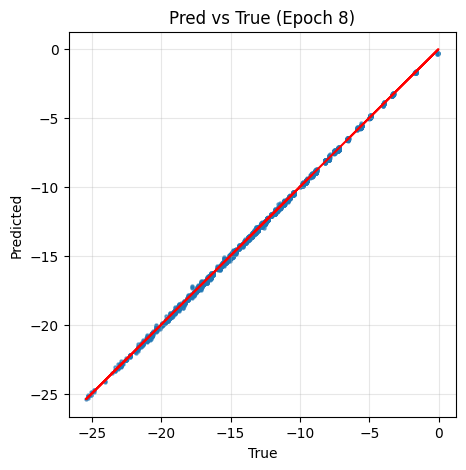

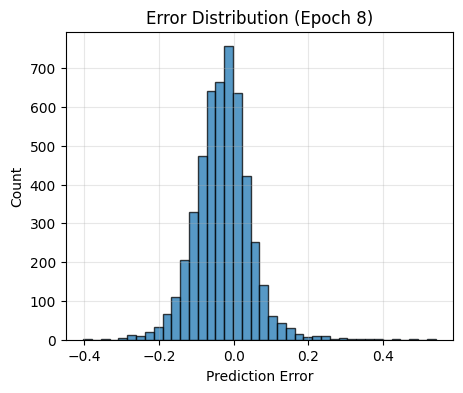

Epoch 8/10 — Train Loss: 0.006925 | Val Loss: 0.006321


New best model saved at epoch 9 (val loss = 0.003852)


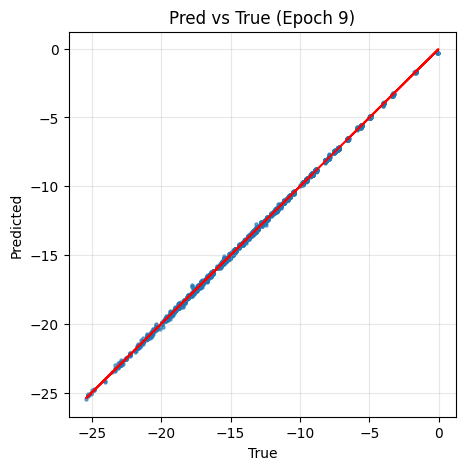

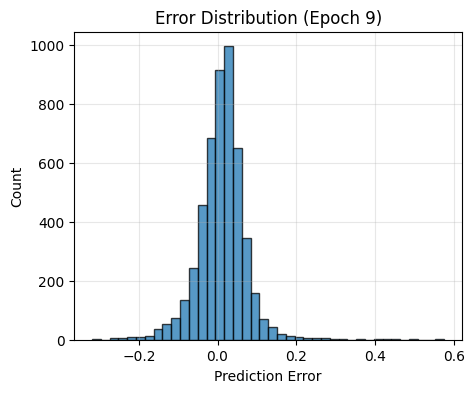

Epoch 9/10 — Train Loss: 0.004984 | Val Loss: 0.003852


New best model saved at epoch 10 (val loss = 0.002955)


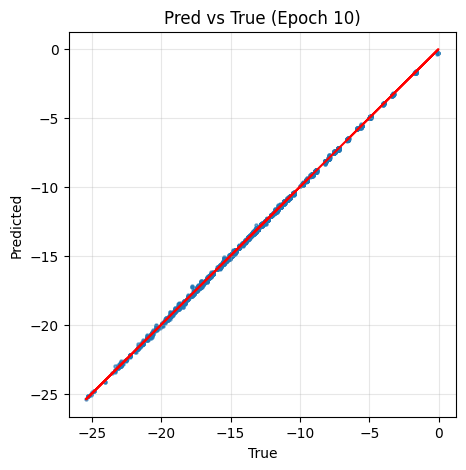

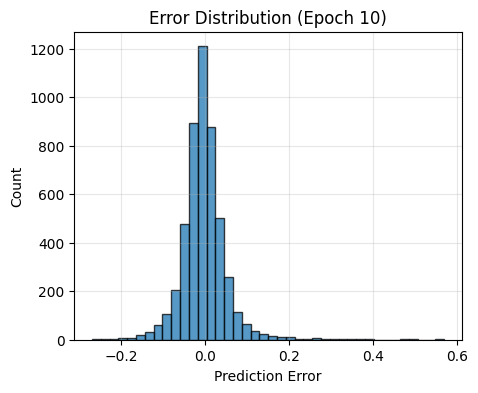

Epoch 10/10 — Train Loss: 0.003870 | Val Loss: 0.002955


In [56]:
epochs = 10

training_dir = "training_baseline"
os.makedirs(training_dir, exist_ok=True)

train_loss_history = []
val_loss_history = []

best_val_loss = float("inf")
best_state_dict = None

# Training Loop

for epoch in range(epochs):


    # TRAIN
    model.train()
    total_train_loss = 0.0

    pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{epochs} [TRAIN]",
        leave=False
    )

    for x, y in pbar:
        y = y.view(-1)                 

        preds = model(x)            
        loss = criterion(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        pbar.set_postfix(train_loss=loss.item())

    mean_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(mean_train_loss)

    scheduler.step()

    # VALIDATION
    model.eval()
    total_val_loss = 0.0
    val_preds = []
    val_trues = []

    with torch.no_grad():
        for x, y in val_loader:
            y = y.view(-1)

            preds = model(x)
            loss = criterion(preds, y)

            total_val_loss += loss.item()
            val_preds.append(preds.cpu())
            val_trues.append(y.cpu())

    mean_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(mean_val_loss)

    val_preds = torch.cat(val_preds)
    val_trues = torch.cat(val_trues)

    # Save best model
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        best_state_dict = model.state_dict()
        torch.save(best_state_dict, model_save_path)
        print(
            f"New best model saved at epoch {epoch+1} "
            f"(val loss = {best_val_loss:.6f})"
        )

    # WE OVERWRITE — TRAIN LOSS
    plt.figure(figsize=(6, 4))
    plt.plot(train_loss_history, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title("Training Loss Curve")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(training_dir, "train_loss.png"))
    plt.close()

    # WE OVERWRITE — VAL LOSS
    plt.figure(figsize=(6, 4))
    plt.plot(val_loss_history, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss Curve")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(training_dir, "val_loss.png"))
    plt.close()

    np.savetxt(
        os.path.join(training_dir, "train_loss.txt"),
        np.array(train_loss_history)
    )

    np.savetxt(
        os.path.join(training_dir, "val_loss.txt"),
        np.array(val_loss_history)
    )

    # TRUE vs PRED
    plt.figure(figsize=(5, 5))
    plt.scatter(
        val_trues.numpy(),
        val_preds.numpy(),
        s=5,
        alpha=0.6
    )
    plt.plot(
        val_trues.numpy(),
        val_trues.numpy(),
        'r'
    )
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"Pred vs True (Epoch {epoch+1})")
    plt.grid(alpha=0.3)
    plt.show()
    plt.close()

    # ERROR HISTOGRAM
    errors = val_preds - val_trues

    plt.figure(figsize=(5, 4))
    plt.hist(
        errors.numpy(),
        bins=40,
        edgecolor="black",
        alpha=0.75
    )
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.title(f"Error Distribution (Epoch {epoch+1})")
    plt.grid(alpha=0.3)
    plt.show()
    plt.close()

    print(
        f"Epoch {epoch+1}/{epochs} — "
        f"Train Loss: {mean_train_loss:.6f} | "
        f"Val Loss: {mean_val_loss:.6f}"
    )

In [57]:
# TEST EVALUATION 
# ----------------

model_path = (
    "best_NN_len=100004_qbits=20_"
    "{Gen=true_L1=32_cp=0.00123418_w=Inf}_"
    "{L2=2_cp=1.0e-15}.pth"
)

model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

print(f"Loaded model from: {model_path}")

test_ints   = [train_ints[i] for i in test_subset_idx]
test_labels = [train_labels[i] for i in test_subset_idx]

test_data = build_fc_dataset(
    test_ints,
    test_labels,
    num_nodes=num_qubits
)

test_loader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False
)

print("Test samples:", len(test_data))

Loaded model from: best_NN_len=100004_qbits=20_{Gen=true_L1=32_cp=0.00123418_w=Inf}_{L2=2_cp=1.0e-15}.pth
Test samples: 5000


In [66]:
# test evaluation
# ----------------
test_loss = 0.0
test_preds = []
test_trues = []

model.eval()

with torch.no_grad():
    for x, y in test_loader:
        y = y.view(-1)         

        preds = model(x)    
        loss = criterion(preds, y)

        test_loss += loss.item()
        test_preds.append(preds.cpu())
        test_trues.append(y.cpu())

mean_test_loss = test_loss / len(test_loader)

y_pred = torch.cat(test_preds).numpy()
y_true = torch.cat(test_trues).numpy()
r2  = r2_score(y_true, y_pred)

print("\nFINAL TEST METRICS")
print(f"Test Loss : {mean_test_loss:.6f}")
print(f"R²        : {r2:.6f}")


FINAL TEST METRICS
Test Loss : 0.003028
MAE       : 0.036558
R²        : 0.999829


COMPARING THE BASELINE WITH THE DEMON MODEL WE CAN OBSERVE A RELEVANT ACCURACY GAIN

**R^2_baseline** = 0.999829 < **R^2_DEMON** = 0.999980

## ABLATION STUDY ON A NEW DATASET
- This dataset contains does not pauli string that are truncated along the propagation. 

In [193]:
json_path = "len=99699_qbits=20_{Gen=true_L1=34_cp=0.00123418_w=Inf}_{L2=2_cp=1.0e-15}.json"

with open(json_path) as f:
    data_dict = json.load(f)

base_name = os.path.splitext(json_path)[0]   
model_save_path = f"best_demon_{base_name}.pth"

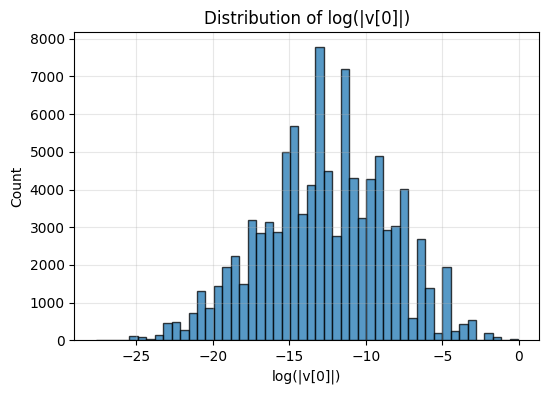

In [194]:
# data_dict contains mulitples possible metrics that can be used as labels.
pauli_ints_raw = [int(k) for k in data_dict.keys()] 
# v[0] is the label we decided to consider: the overlap with zero.
vals_v0_raw = [float(v[0]) for v in data_dict.values()]
vals_v0_abs = [abs(v) for v in vals_v0_raw]          

# Filter out very small values 
# since we cannot apply log function on them.
filtered_pauli_ints = []
filtered_vals_abs = []

# ----------------------------------------------------------
for p, val_abs in zip(pauli_ints_raw, vals_v0_abs):
    if val_abs >= 1e-40:
        filtered_pauli_ints.append(p)
        filtered_vals_abs.append(val_abs)

# Take log-scale of the values
labels = torch.log(torch.tensor(filtered_vals_abs, dtype=torch.float))
# ----------------------------------------------------------

# Plot distribution of the labels 
# (log-values)
plt.figure(figsize=(6,4))
plt.hist(labels.numpy(), bins=50, alpha=0.75, edgecolor="black")
plt.xlabel("log(|v[0]|)")
plt.ylabel("Count")
plt.title("Distribution of log(|v[0]|)")
plt.grid(alpha=0.3)
plt.show()

In [195]:
# Train / Test Split
# ----------------------
train_ints, test_ints, train_labels, test_labels = train_test_split(
    filtered_pauli_ints, labels, test_size=0.05, random_state=42
)

train_graphs = build_graph_dataset(train_ints, train_labels, num_qubits)
test_graphs = build_graph_dataset(test_ints, test_labels, num_qubits)

print("Train graphs:", len(train_graphs))
print("Test graphs:", len(test_graphs))

# DataLoaders
# ------------
train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_graphs,   batch_size=1, shuffle=False)

/var/folders/n_/nv7jjvvn7kvbmnzcz9d1hjzr0000gn/T/ipykernel_2569/1730673205.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  P_indices = torch.tensor(P_indices, dtype=torch.long).view(-1)


Train graphs: 94095
Test graphs: 4953


In [196]:
# Model
# -------
model = Demon(num_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
T_max = 10  

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=T_max,
    eta_min=1e-5    
)

In [197]:
J = 1
epochs = 10

training_dir = "training"
os.makedirs(training_dir, exist_ok=True)

train_loss_history = []
test_loss_history = []

best_test_loss = float("inf")
best_state_dict = None

# TRAINING LOOP + TEST EVAL
for epoch in range(epochs):

    # TRAIN
    model.train()
    total_train_loss = 0.0

    pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{epochs} [TRAIN]",
        leave=False
    )

    for data in pbar:
        x = data.x
        edge_index = data.edge_index
        target = data.y.squeeze()

        pred = model(x, edge_index, J)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        pbar.set_postfix(train_loss=loss.item())

    mean_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(mean_train_loss)

    scheduler.step()

    # TEST
    model.eval()
    total_test_loss = 0.0

    with torch.no_grad():
        for test_data in test_loader:
            x = test_data.x
            edge_index = test_data.edge_index
            target = test_data.y.squeeze()

            pred = model(x, edge_index, J)
            loss = criterion(pred, target)

            total_test_loss += loss.item()

    mean_test_loss = total_test_loss / len(test_loader)
    test_loss_history.append(mean_test_loss)

    # SAVE BEST MODEL (BY TEST LOSS)
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
        best_state_dict = model.state_dict()
        torch.save(best_state_dict, model_save_path)
        print(
            f"New best model saved at epoch {epoch+1} "
            f"(test loss = {best_test_loss:.6f})"
        )

    # Train loss plot
    plt.figure(figsize=(6, 4))
    plt.plot(train_loss_history, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title("Training Loss Curve")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(training_dir, "train_loss.png"))
    plt.close()

    # Test loss plot
    plt.figure(figsize=(6, 4))
    plt.plot(test_loss_history, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Test Loss")
    plt.title("Test Loss Curve")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(training_dir, "test_loss.png"))
    plt.close()

    np.savetxt(
        os.path.join(training_dir, "train_loss.txt"),
        np.array(train_loss_history)
    )
    np.savetxt(
        os.path.join(training_dir, "test_loss.txt"),
        np.array(test_loss_history)
    )

    print(
        f"Epoch {epoch+1}/{epochs} — "
        f"Train Loss: {mean_train_loss:.6f} | "
        f"Test Loss: {mean_test_loss:.6f}"
    )

New best model saved at epoch 1 (test loss = 0.002063)
Epoch 1/10 — Train Loss: 0.345297 | Test Loss: 0.002063


Epoch 2/10 — Train Loss: 0.007954 | Test Loss: 0.009316


New best model saved at epoch 3 (test loss = 0.000631)
Epoch 3/10 — Train Loss: 0.005339 | Test Loss: 0.000631


Epoch 4/10 — Train Loss: 0.003306 | Test Loss: 0.001485


Epoch 5/10 — Train Loss: 0.002412 | Test Loss: 0.000687


New best model saved at epoch 6 (test loss = 0.000315)
Epoch 6/10 — Train Loss: 0.001633 | Test Loss: 0.000315


Epoch 7/10 — Train Loss: 0.001175 | Test Loss: 0.000914


Epoch 8/10 — Train Loss: 0.000713 | Test Loss: 0.000546


New best model saved at epoch 9 (test loss = 0.000314)
Epoch 9/10 — Train Loss: 0.000443 | Test Loss: 0.000314


Epoch 10/10 — Train Loss: 0.000283 | Test Loss: 0.000389
